# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [144]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 100)

# magic word for producing visualizations in notebook
%matplotlib inline



### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [145]:
# Load in the general demographics data.
azdias = pd.read_csv('./Udacity_AZDIAS_Subset.csv',
                     delimiter = ";" )

# Load in the feature summary file.
feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv',
                        delimiter = ";" )

In [146]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,WOHNLAGE,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,886367.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,817722.000000,817722.000000,891221.000000,891221.000000,817722.000000,817722.000000,817722.000000,872873.000000,306609.000000,783619.000000,817722.000000,798073.000000,794213.000000,798073.000000,817252.000000,798073.000000,798073.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,757897.000000,797481.000000,797481.000000,797481.000000,798066.000000,770025.000000,757897.000000,886367.000000,770025.000000,785421.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,3.790586,1101.178533,7.350304,0.196612,1.792102,14.622637,4.453621,3.599574,2.185966,4.791151,2.432575,1.026827,8.154346,3.419630,3.945860,4.272729,4.240609,4.001597,4.023709,4.359086,4.481405,4.025014,3.910139,4.763223,4.667550,4.445007,4.256076,3.661784,1.266967,0.008423,0.003483,1.197852,3.362438,10.864126,1.727637,0.004162,4.207243,3.410640,3.933406,7.908791,8.287263,0.040647,2.798641,3.018452,1993.277011,4.052836,1.494277,1.265584,0.624525,0.305927,1.389552,3.158580,4.153043,3.939172,4.549491,3.738306,2.592991,2.963540,2.698691,4.257967,619.701439,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,1.987876,976.583551,3.525723,0.397437,1.269062,12.616883,3.855639,3.926486,1.756537,3.425305,1.474315,0.586634,4.844532,1.417741,1.946564,1.915885,2.007373,1.857540,2.077746,2.022829,1.807552,1.903816,1.580306,1.830789,1.795712,1.852412,1.770137,1.707637,1.287435,0.091392,0.084957,0.952532,1.352704,7.639683,1.155849,0.068855,1.624057,1.628844,1.964701,1.923137,15.628087,0.324028,2.656713,1.550312,3.332739,1.949539,1.403961,1.245178,1.013443,0.638725,1.779483,1.329537,2.183710,1.718996,2.028919,0.923193,1.119052,1.428882,1.521524,2.030385,340.034318,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000

In [147]:
azdias.head(10)

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GEBURTSJAHR,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,TITEL_KZ,VERS_TYP,ZABEOTYP,ALTER_HH,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,KK_KUNDENTYP,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_BAUMAX,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,4,0,10.0,0,-1,15.0,4.0,2.0,2.0,1.0,1.0,0,0,5.0,2,6,7,5,1,5,3,3,4,7,6,6,5,3,-1,NaN,NaN,-1,3,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,1,1996,10.0,0,3,21.0,6.0,5.0,3.0,2.0,1.0,1,14,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3,1.0,0.0,2,5,0.0,2.0,0.0,6.0,NaN,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,5.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,1,1979,10.0,1,3,3.0,1.0,1.0,1.0,3.0,2.0,1,15,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2,0.0,0.0,1,5,17.0,1.0,0.0,4.0,NaN,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,6,1957,1.0,0,2,0.0,0.0,0.0,0.0,9.0,4.0,1,8,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1,0.0,0.0,1,3,13.0,0.0,0.0,1.0,NaN,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,1.0,4.0,4.0,2.0,6.0,4.0,0.0,4.0,1.0,0.0,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,5,1963,5.0,0,3,32.0,10.0,10.0,5.0,3.0,2.0,1,8,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2,0.0,0.0,2,4,20.0,4.0,0.0,5.0,1.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0
5,3,1,2,2.0,3,1,5,2,2,5,2,1943,1.0,0,3,8.0,2.0,1.0,1.0,4.0,2.0,1,3,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0,0.0,0.0,2,4,10.0,1.0,0.0,5.0,3.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,W,7.0,8,8C,54,2.0,2.0,0.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0
6,-1,2,2,5.0,1,5,1,5,4,3,4,0,12.0,0,2,2.0,1.0,1.0,1.0,2.0,1.0,1,10,4.0,2,5,5,7,2,6,5,5,7,7,4,7,7,7,1,0.0,0.0,1,4,0.0,1.0,0.0,6.0,NaN,3.0,9.0,4.0,0.0,1.0,5.0,1992.0,W,5.0,4,4A,22,3.0,2.0,0.0,0.0,1.0,3.0,6.0,4.0,3.0,5.0,3.0,5.0,2.0,5.0,867.0,3.0,3.0,1.0,0.0,1.0,5.0,5.0,4.0,6.0,3.0
7,-1,1,1,3.0,3,3,4,1,3,2,5,1964,9.0,0,1,5.0,2.0,1.0,1.0,1.0,1.0,1,8,5.0,7,7,7,5,6,2,2,7,5,1,1,2,5,5,0,0.0,0.0,1,1,14.0,1.0,0.0,4.0,NaN,5.0,9.0,6.0,0.0,8.0,3.0,1992.0,W,1.0,2,2D,14,2.0,2.0,0.0,0.0,0.0,4.0,2.0,5.0,3.0,4.0,1.0,4.0,1.0,1.0,758.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,2.0,5.0,2.0
8,-1,3,1,3.0,4,4,2,4,2,2,6,1974,3.0,1,3,10.0,3.0,1.0,1.0,10.0,5.0,1,11,4.0,4,5,4,1,5,6,4,5,2,5,5,3,1,4,3,0.0,0.0,2,6,16.0,1.0,0.0,3.0,NaN,5.0,8.0,2.0,1.0,3.0,4.0,1992.0,W,1.0,1,1A,13,1.0,1.0,0.0,0.0,0.0,5.0,3.0,4.0,4.0,4.0,1.0,3.0,2.0,3.0,511.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,4.0,3.0
9,-1,3,2,4.0,2,4,2,3,5,4,1,1975,12.0,1,2,4.0,1.0,1.0,1.0,3.0,2.0,1,15,4.0,2,1,1,3,2,6,6,3,4,7,6,7,1,3,3,0.0,0.0,2,4,17.0,1.0,0.0,4.0,6.0,4.0,3.0,9.0,0.0,3.0,4.0,1992.0,W,7.0,1,1E,15,1.0,3.0,1.0,0.0,0.0,2.0,6.0,5.0,4.0,3.0,1.0,3.0,3.0,1.0,530.0,2.0,3.0,2.0,1.0,1.0,3.0,3.0,2.0,3.0,1.0


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [148]:
def convert_int(x):
    try:
        output = int(x)
        return output
    except ValueError:
        return x

In [149]:
def get_missing_dict(feat_info_df):
    missing_dict = {}
    for row in feat_info_df.itertuples():
        value = row[4]
        value = value.replace('[','')
        value = value.replace(']','')
        value = value.split(',')
        data_list = []
        for data in value:
            data_list.append(convert_int(data))
        missing_dict[row[1]] = data_list
    return missing_dict

In [150]:
def check_missing(x, missing_list):

    for value in missing_list:
        if x == value:
            return np.nan # if data in column is equal to 'ANY' of the values,
                          # immediately stop the function, else continue
    return x        

In [151]:
def get_complete_missing_df(original_df, feat_info_df):
    missing_dict = get_missing_dict(feat_info_df)
    new_df = pd.DataFrame()
    for i, row in original_df.iteritems():
        new_row = pd.DataFrame(row.map(lambda x: check_missing(x, missing_dict[i])))
        new_df = pd.concat([new_df,new_row], axis = 1)
    return new_df

In [152]:
azdias_new = get_complete_missing_df(azdias, feat_info)

In [153]:
null_values_original = azdias.isnull().sum(axis = 0)
null_values_new = azdias_new.isnull().sum(axis = 0)

In [154]:
print('{} were the old null values, while {} are new null values, which is {:.2f}% higher'.format(
null_values_original.sum(), null_values_new.sum(),
    (null_values_new.sum()/null_values_original.sum() -1)*100 ))

4896838 were the old null values, while 8373929 are new null values, which is 71.01% higher


#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [155]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
no_rows = azdias_new.shape[0]
null_values_percent = null_values_new.divide(no_rows/100)
null_values_percent = null_values_percent.sort_values(ascending = False)
null_values_percent

TITEL_KZ                 99.757636
AGER_TYP                 76.955435
KK_KUNDENTYP             65.596749
KBA05_BAUMAX             53.468668
GEBURTSJAHR              44.020282
ALTER_HH                 34.813699
REGIOTYP                 17.735668
KKK                      17.735668
W_KEIT_KIND_HH           16.605084
KBA05_ANTG4              14.959701
KBA05_GBZ                14.959701
MOBI_REGIO               14.959701
KBA05_ANTG1              14.959701
KBA05_ANTG2              14.959701
KBA05_ANTG3              14.959701
PLZ8_GBZ                 13.073637
PLZ8_HHZ                 13.073637
PLZ8_BAUMAX              13.073637
PLZ8_ANTG4               13.073637
PLZ8_ANTG1               13.073637
PLZ8_ANTG3               13.073637
PLZ8_ANTG2               13.073637
SHOPPER_TYP              12.476816
VERS_TYP                 12.476816
HEALTH_TYP               12.476816
NATIONALITAET_KZ         12.153551
PRAEGENDE_JUGENDJAHRE    12.136608
KBA13_ANZAHL_PKW         11.871354
ANZ_HAUSHALTE_AKTIV 

(array([ 39.,  40.,   0.,   1.,   1.,   1.,   1.,   1.,   0.,   1.]),
 array([  0.        ,   9.97576359,  19.95152717,  29.92729076,
         39.90305435,  49.87881794,  59.85458152,  69.83034511,
         79.8061087 ,  89.78187229,  99.75763587]),
 <a list of 10 Patch objects>)

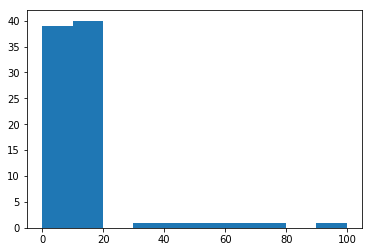

In [156]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(null_values_percent)

In [157]:
null_values_percent[null_values_percent > 20].index.tolist()

['TITEL_KZ',
 'AGER_TYP',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX',
 'GEBURTSJAHR',
 'ALTER_HH']

In [160]:
def remove_columns(df_new, threshold = 20):
    
    no_rows = df_new.shape[0]
    null_values_columns = df_new.isnull().sum(axis = 0)
    null_values_columns_percent = null_values_columns.divide(no_rows/100)
    columns_to_be_removed =  null_values_columns_percent[
        null_values_columns_percent > threshold].index.tolist()
    df_processed_columns = df_new.drop(columns_to_be_removed, axis = 1)
    return df_processed_columns

In [161]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

azdias_processed = remove_columns(azdias_new)

#### Discussion 1.1.2: Assess Missing Data in Each Column

(Double click this cell and replace this text with your own text, reporting your observations regarding the amount of missing data in each column. Are there any patterns in missing values? Which columns were removed from the dataset?)

* Most of the missing values occur in cohorts
  * All Macro cell features (PLZ8) have 13% missing values
  * Micro Cell features (KBA) have around 15% missing values
* There are only 6 features which have more than 20% missing values
* A lot of individual features like personality typology, and finance information have no null values 
* Columns removed from the dataset
  * TITEL_KZ
  * AGER_TYP
  * KK_KUNDENTYP
  * KBA05_BAUMAX
  * GEBURTSJAHR
  * ALTER_HH

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [162]:
# How much data is missing in each row of the dataset?
null_values_rows = azdias_processed.isnull().sum(axis = 1)
null_values_rows = null_values_rows.divide(azdias_processed.shape[1]/100)

(array([  6.97109000e+05,   7.76340000e+04,   1.28010000e+04,
          9.53300000e+03,   8.29000000e+02,   1.55000000e+02,
          1.40160000e+04,   5.03100000e+03,   2.80380000e+04,
          4.60750000e+04]),
 array([  0.        ,   6.20253165,  12.40506329,  18.60759494,
         24.81012658,  31.01265823,  37.21518987,  43.41772152,
         49.62025316,  55.82278481,  62.02531646]),
 <a list of 10 Patch objects>)

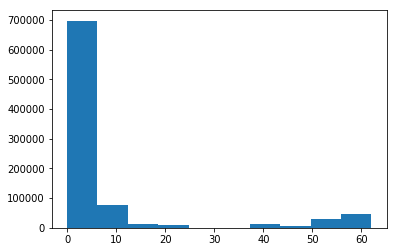

In [163]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
plt.hist(null_values_rows)


Two big groupings of data can be
* Rows with **less than 10%** missing values
* Rows with **greater than 10%** missing values

In [168]:
def get_null_segment(x, threshold = 10):
    if x > threshold:
        return 'High'
    else:
        return 'Low'

In [169]:
null_values_rows_df = pd.DataFrame(null_values_rows, columns = ['null_values_rows_percent'])
azdias_null_rows_info = pd.concat([azdias_processed,null_values_rows_df], axis = 1)
azdias_null_rows_info['null_values_rows_category'] = azdias_null_rows_info['null_values_rows_percent'].map(get_null_segment)
azdias_null_rows_info_high = azdias_null_rows_info[azdias_null_rows_info['null_values_rows_category'] == 'High']
azdias_null_rows_info_low = azdias_null_rows_info[azdias_null_rows_info['null_values_rows_category'] == 'Low']

In [170]:
def remove_rows(df, threshold = 10):
    null_values_rows = df.isnull().sum(axis = 1)
    null_values_rows = null_values_rows.divide(df.shape[1]/100)
    null_values_rows_df = pd.DataFrame(null_values_rows, columns = ['null_values_rows_percent'])
    null_values_rows_df = pd.concat([df,null_values_rows_df], axis = 1)
    null_values_rows_df['null_values_rows_category'] = null_values_rows_df[
        'null_values_rows_percent'].map(lambda x : get_null_segment(x, threshold))
    new_df = null_values_rows_df[null_values_rows_df[
        'null_values_rows_category'] == 'Low']
    return new_df

In [171]:
azdias_null_rows_info_low = remove_rows(azdias_processed)

In [173]:
print(azdias_null_rows_info_high.shape)
print(azdias_null_rows_info_low.shape)

(144112, 81)
(747109, 81)


In [174]:
non_nan_columns_high = set(azdias_null_rows_info_high.dropna(axis = 1).columns)
non_nan_columns_low = set(azdias_null_rows_info_low.dropna(axis = 1).columns)
common_columns = list(non_nan_columns_high & non_nan_columns_low)
common_columns.remove('null_values_rows_category')
common_columns.remove('null_values_rows_percent')
common_columns

['ZABEOTYP',
 'FINANZ_MINIMALIST',
 'GREEN_AVANTGARDE',
 'FINANZ_HAUSBAUER',
 'SEMIO_KULT',
 'SEMIO_DOM',
 'SEMIO_RAT',
 'SEMIO_PFLICHT',
 'FINANZ_ANLEGER',
 'FINANZ_SPARER',
 'SEMIO_VERT',
 'SEMIO_MAT',
 'SEMIO_FAM',
 'SEMIO_SOZ',
 'FINANZTYP',
 'FINANZ_UNAUFFAELLIGER',
 'SEMIO_LUST',
 'FINANZ_VORSORGER',
 'SEMIO_REL',
 'SEMIO_KAEM',
 'ANREDE_KZ',
 'SEMIO_TRADV',
 'SEMIO_KRIT',
 'SEMIO_ERL']

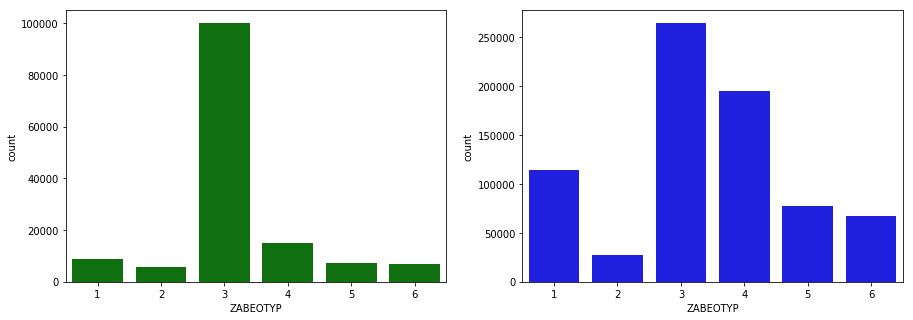

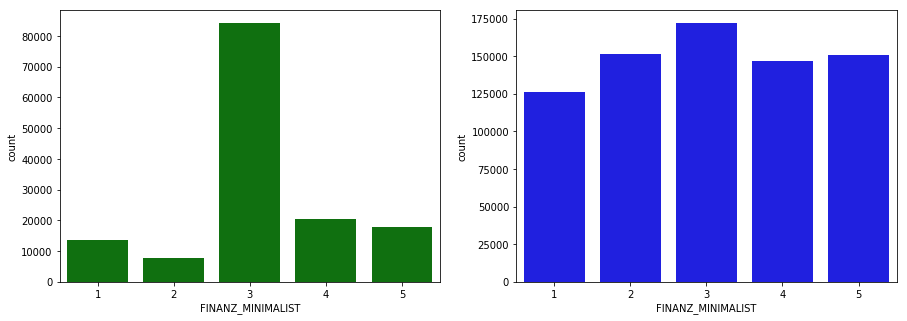

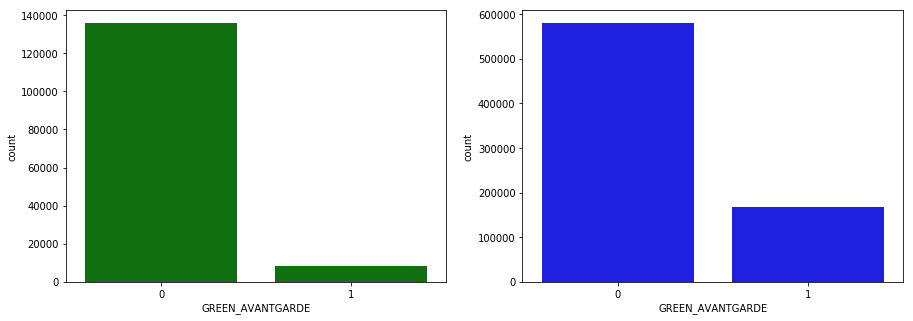

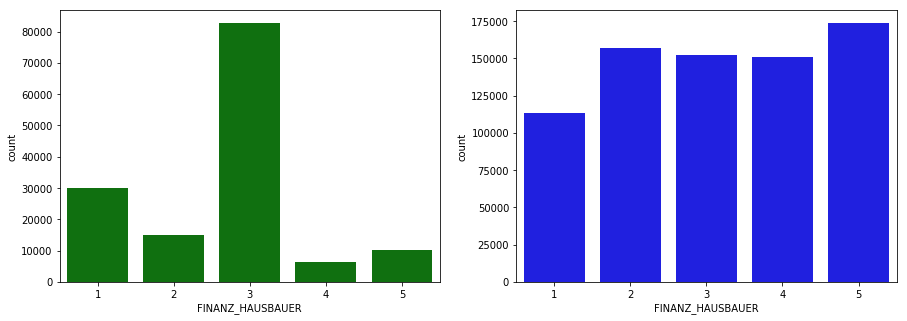

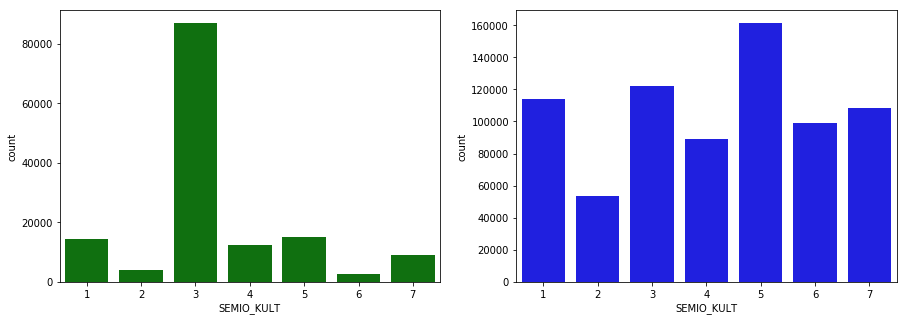

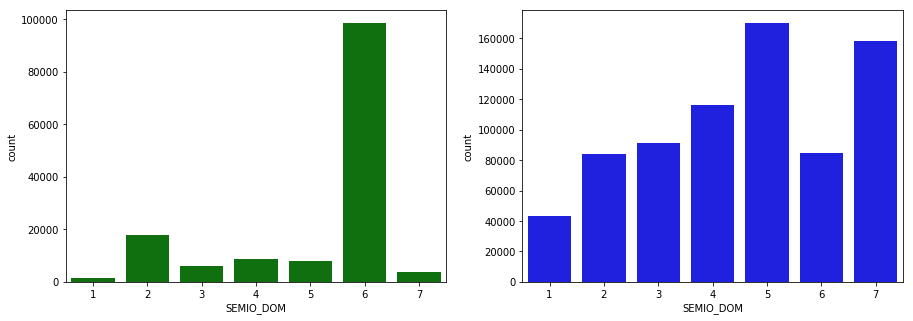

In [175]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

for i in range(6):
    fig, axes = plt.subplots(1,2, figsize=(15, 5))
    sns.countplot(common_columns[i], data = azdias_null_rows_info_high , ax=axes[0], color='green')
    sns.countplot(common_columns[i], data = azdias_null_rows_info_low, ax=axes[1], color='blue')

In [176]:
print ('{0:.0f}% rows have null values below 10%'.format(
    azdias_null_rows_info_low.shape[0]/azdias_null_rows_info.shape[0]*100))

84% rows have null values below 10%


#### Discussion 1.1.3: Assess Missing Data in Each Row

* 84% of the observations have less than 10% missing values
* The data for columns value distribution is **very distinct for High NAN rows vs Low NAN rows**

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [177]:
# How many features are there of each data type?

feat_info['type'].value_counts()

ordinal        49
categorical    21
numeric         7
mixed           7
interval        1
Name: type, dtype: int64

In [178]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [179]:
azdias_null_rows_info_low.head(5)

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,NATIONALITAET_KZ,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SHOPPER_TYP,SOHO_KZ,VERS_TYP,ZABEOTYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,GEBAEUDETYP,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_DEUG_2015,CAMEO_DEU_2015,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,null_values_rows_percent,null_values_rows_category
1,1.0,2,5.0,1,5,2,5,4,5,1,10.0,0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,1.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,3.0,1.0,2.0,5,2.0,0.0,6.0,3.0,9.0,11.0,0.0,8.0,1.0,1992.0,W,4.0,8,8A,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0.000000,Low
2,3.0,2,3.0,1,4,1,2,3,5,1,10.0,1,3.0,3.0,1.0,1.0,1.0,3.0,2.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,2.0,0.0,1.0,5,1.0,0.0,4.0,3.0,9.0,10.0,0.0,1.0,5.0,1992.0,W,2.0,4,4C,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0.000000,Low
3,4.0,2,2.0,4,2,5,2,1,2,6,1.0,0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,1.0,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,1.0,0.0,1.0,3,0.0,0.0,1.0,NaN,9.0,1.0,0.0,1.0,4.0,1997.0,W,7.0,2,2A,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,8.860759,Low
4,3.0,1,5.0,4,3,4,1,3,2,5,5.0,0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,1.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,2.0,0.0,2.0,4,4.0,0.0,5.0,2.0,9.0,3.0,0.0,1.0,4.0,1992.0,W,3.0,6,6B,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0.000000,Low
5,1.0,2,2.0,3,1,5,2,2,5,2,1.0,0,3.0,8.0,2.0,1.0,1.0,4.0,2.0,1.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,0.0,2.0,4,1.0,0.0,5.0,6.0,9.0,5.0,0.0,1.0,5.0,1992.0,W,7.0,8,8C,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0.000000,Low


In [181]:
def get_feature_information_df(df, feat_info = feat_info):
    feature_information_list = []
    for column, row in df.iteritems():
        if column not in ('null_values_rows_percent', 'null_values_rows_category'):
            feature_information_list.append({
                'Column': column,
                'Type': feat_info[feat_info['attribute'] == column]['type'].iloc[0],
                'DataType': df[column].dtype,
                'Unique Values': row.dropna().unique().tolist()
            })
    feature_information_df = pd.DataFrame(feature_information_list)
    feature_information_df['count_unique_values'] = feature_information_df['Unique Values'].map(len)
    return feature_information_df

In [182]:
feature_information_df = get_feature_information_df(azdias_null_rows_info_low)

In [183]:
feature_information_df[
    (feature_information_df['Type'] == 'categorical') & (feature_information_df['DataType'] == 'object')
& (feature_information_df['count_unique_values'] <= 2)]

,Column,DataType,Type,Unique Values,count_unique_values
50,OST_WEST_KZ,object,categorical,"[W, O]",2


* As OST_WEST_KZ has two non numerical values, it will be **encoded**
* Categorical columns with greater than 2 values will be **dropped**

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

There is only one categorical value with 2 non numeric values, it will have to be encoded

In [184]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

def encode_categorical_variable(df):
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace(
        {'O': 0, 'W': 1}
    )
    return df

In [185]:
azdias_null_rows_info_low = encode_categorical_variable(azdias_null_rows_info_low)

In [186]:
# Re-encode categorical variable(s) to be kept in the analysis.

azdias_null_rows_info_low['OST_WEST_KZ'].value_counts()

1    587514
0    159595
Name: OST_WEST_KZ, dtype: int64

All categorical columns will greater than 2 values will be dropped

In [187]:
def drop_categorical_columns(df, feature_information_df):

    columns_tobe_dropped = feature_information_df[
    (feature_information_df['Type'] == 'categorical') & (
        feature_information_df['count_unique_values'] > 2)]['Column'].tolist()
    new_df = df.drop(columns_tobe_dropped, axis = 1)
    return new_df
    

In [188]:
azdias_null_rows_info_low = drop_categorical_columns(azdias_null_rows_info_low, feature_information_df )

In [189]:
azdias_null_rows_info_low.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,null_values_rows_percent,null_values_rows_category
1,1.0,2,1,5,2,5,4,5,0,3.0,21.0,6.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,1,4.0,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0.000000,Low
2,3.0,2,1,4,1,2,3,5,1,3.0,3.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,1,2.0,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0.000000,Low
3,4.0,2,4,2,5,2,1,2,0,2.0,NaN,NaN,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,1.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,1,7.0,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,8.860759,Low
4,3.0,1,4,3,4,1,3,2,0,3.0,32.0,10.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,1,3.0,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0.000000,Low
5,1.0,2,3,1,5,2,2,5,0,3.0,8.0,2.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,2.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,1,7.0,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0.000000,Low


#### Discussion 1.2.1: Re-Encode Categorical Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding categorical features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

As OST_WEST_KZ has two values, it will be **encoded**, and the rest of them will be **dropped**

**OST_WEST_KZ** determines if the building location is in former East or West Germany. 
A dictionary is used to encode this variable
{'O': 0, 
 'W': 1}
0 is used for 'O' (East), and 1 for 'W'(West) 

Columns with more than 2 values will be dropped
['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015',
 'CAMEO_DEU_2015']

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [190]:
feature_information_df[feature_information_df['Type'] == 'mixed']

,Column,DataType,Type,Unique Values,count_unique_values
13,LP_LEBENSPHASE_FEIN,float64,mixed,"[21.0, 3.0, 32.0, 8.0, 2.0, 5.0, 10.0, 4.0, 6....",40
14,LP_LEBENSPHASE_GROB,float64,mixed,"[6.0, 1.0, 10.0, 2.0, 3.0, 5.0, 7.0, 12.0, 11....",12
20,PRAEGENDE_JUGENDJAHRE,float64,mixed,"[14.0, 15.0, 8.0, 3.0, 10.0, 11.0, 9.0, 6.0, 4...",15
51,WOHNLAGE,float64,mixed,"[4.0, 2.0, 7.0, 3.0, 5.0, 1.0, 8.0, 0.0]",8
54,CAMEO_INTL_2015,object,mixed,"[51, 24, 12, 43, 54, 22, 14, 13, 15, 41, 34, 5...",21
73,PLZ8_BAUMAX,float64,mixed,"[1.0, 2.0, 4.0, 5.0, 3.0]",5


In [191]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

azdias_null_rows_info_low['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    172952
8.0     134165
5.0      81722
10.0     80527
3.0      51784
15.0     39536
11.0     33173
9.0      32493
6.0      25120
12.0     23337
4.0      20068
1.0      19583
2.0       7340
13.0      5300
7.0       3888
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [192]:
azdias_null_rows_info_low['PRAEGENDE_JUGENDJAHRE'].unique()

array([ 14.,  15.,   8.,   3.,  10.,  11.,   9.,   6.,   4.,  nan,   5.,
         2.,   1.,  12.,  13.,   7.])

### 1.18. PRAEGENDE_JUGENDJAHRE
Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west)
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)


In [193]:
age_category = {
    1: '40s',
    2: '50s',
    3: '60s',
    4: '70s',
    5: '80s',
    6: '90s'    
}

age_category_dict = {
    1:1,
    2:1,
    3:2,
    4:2,
    5:3,
    6:3,
    7:3,
    8:4,
    9:4,
    10:5,
    11:5,
    12:5,
    13:5,
    14:6,
    15:6    
}

movement_category = {
    
    1: 'Mainstream',
    2: 'Avantgarde'
}

movement_category_dict = {
    1:1,
    2:2,
    3:1,
    4:2,
    5:1,
    6:2,
    7:2,
    8:1,
    9:2,
    10:1,
    11:2,
    12:1,
    13:2,
    14:1,
    15:2    
}

In [194]:
def get_new_features_praegende_judengjahre(df):
    df['age_category'] = df['PRAEGENDE_JUGENDJAHRE'].map(
        age_category_dict)
    df['movement_category'] = df['PRAEGENDE_JUGENDJAHRE'].map(
    movement_category_dict)
    
    return df

In [195]:
azdias_null_rows_info_low = get_new_features_praegende_judengjahre(azdias_null_rows_info_low)

In [196]:
azdias_null_rows_info_low.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,WOHNLAGE,CAMEO_INTL_2015,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,null_values_rows_percent,null_values_rows_category,age_category,movement_category
1,1.0,2,1,5,2,5,4,5,0,3.0,21.0,6.0,14.0,1.0,5,4,4,3,1,2,2,3,6,4,7,4,7,6,1.0,2.0,2.0,0.0,6.0,3.0,9.0,11.0,0.0,1.0,1992.0,1,4.0,51,0.0,0.0,0.0,2.0,1.0,6.0,3.0,8.0,3.0,2.0,1.0,3.0,3.0,963.0,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0,0.000000,Low,6.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,3.0,1.0,15.0,3.0,4,1,3,3,4,4,6,3,4,7,7,7,3,3,0.0,1.0,1.0,0.0,4.0,3.0,9.0,10.0,0.0,5.0,1992.0,1,2.0,24,1.0,3.0,1.0,0.0,3.0,2.0,4.0,4.0,4.0,2.0,3.0,2.0,2.0,712.0,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0,0.000000,Low,6.0,2.0
3,4.0,2,4,2,5,2,1,2,0,2.0,NaN,NaN,8.0,2.0,5,1,2,1,4,4,7,4,3,4,4,5,4,4,0.0,1.0,0.0,0.0,1.0,NaN,9.0,1.0,0.0,4.0,1997.0,1,7.0,12,4.0,1.0,0.0,0.0,4.0,4.0,2.0,6.0,4.0,NaN,4.0,1.0,NaN,596.0,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0,8.860759,Low,4.0,1.0
4,3.0,1,4,3,4,1,3,2,0,3.0,32.0,10.0,8.0,5.0,6,4,4,2,7,4,4,6,2,3,2,2,4,2,0.0,2.0,4.0,0.0,5.0,2.0,9.0,3.0,0.0,4.0,1992.0,1,3.0,43,1.0,4.0,1.0,0.0,3.0,2.0,5.0,1.0,5.0,3.0,3.0,5.0,5.0,435.0,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0,0.000000,Low,4.0,1.0
5,1.0,2,3,1,5,2,2,5,0,3.0,8.0,2.0,3.0,3.0,2,4,7,4,2,2,2,5,7,4,4,4,7,6,0.0,2.0,1.0,0.0,5.0,6.0,9.0,5.0,0.0,5.0,1992.0,1,7.0,54,2.0,2.0,0.0,0.0,4.0,6.0,2.0,7.0,4.0,4.0,4.0,1.0,5.0,1300.0,2.0,3.0,1.0,1.0,1.0,5.0,5.0,2.0,3.0,3.0,0.000000,Low,2.0,1.0


### 4.3. CAMEO_INTL_2015
German CAMEO: Wealth / Life Stage Typology, mapped to international code
- -1: unknown
- 11: Wealthy Households - Pre-Family Couples & Singles
- 12: Wealthy Households - Young Couples With Children
- 13: Wealthy Households - Families With School Age Children
- 14: Wealthy Households - Older Families &  Mature Couples
- 15: Wealthy Households - Elders In Retirement
- 21: Prosperous Households - Pre-Family Couples & Singles
- 22: Prosperous Households - Young Couples With Children
- 23: Prosperous Households - Families With School Age Children
- 24: Prosperous Households - Older Families & Mature Couples
- 25: Prosperous Households - Elders In Retirement
- 31: Comfortable Households - Pre-Family Couples & Singles
- 32: Comfortable Households - Young Couples With Children
- 33: Comfortable Households - Families With School Age Children
- 34: Comfortable Households - Older Families & Mature Couples
- 35: Comfortable Households - Elders In Retirement
- 41: Less Affluent Households - Pre-Family Couples & Singles
- 42: Less Affluent Households - Young Couples With Children
- 43: Less Affluent Households - Families With School Age Children
- 44: Less Affluent Households - Older Families & Mature Couples
- 45: Less Affluent Households - Elders In Retirement
- 51: Poorer Households - Pre-Family Couples & Singles
- 52: Poorer Households - Young Couples With Children
- 53: Poorer Households - Families With School Age Children
- 54: Poorer Households - Older Families & Mature Couples
- 55: Poorer Households - Elders In Retirement
- XX: unknown

In [197]:
wealth_category = {
    1: 'Wealthy Households',
    2: 'Prosperous Households',
    3: 'Comfortable Households',
    4: 'Less Affluent Households',
    5: 'Poorer Households'
}

life_stage_category = {
    1: 'Pre-Family Couples & Singles',
    2: 'Young Couples With Children',
    3: 'Families With School Age Children',
    4: 'Older Families &  Mature Couples',
    5: 'Elders In Retirement'
}

In [198]:
def get_wealth_category(x):
    try:
        x = int(x) # Evoke the ValueError, and doesn't convert NAN to string.
                   # math.isnan() wasn't able to identify nan in the data
        x = str(x)
        x = int(x[0])
        return x
    except ValueError:
        return x

def get_life_stage_category(x):
    try:
        x = int(x) # Evoke the ValueError, and doesn't convert NAN to string.
                   # math.isnan() wasn't able to identify nan in the data
        x = str(x)
        x = int(x[1])
        return x
    except ValueError:
        return x

In [199]:
def get_new_features_cameo_intl_2015(df):
    
    df['wealth_category'] = df['CAMEO_INTL_2015'].map(
        get_wealth_category)
    df['life_stage_category'] = df['CAMEO_INTL_2015'].map(
        get_life_stage_category)
    return df

In [200]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_null_rows_info_low = get_new_features_cameo_intl_2015(azdias_null_rows_info_low)

In [201]:
def drop_mixed_features(df,feature_information_df):
    mixed_columns = feature_information_df[
        feature_information_df['Type'] == 'mixed']['Column'].tolist()
    
    df = df.drop(mixed_columns, axis = 1)
    return df

In [202]:
azdias_null_rows_info_low = drop_mixed_features(azdias_null_rows_info_low, feature_information_df)

#### Discussion 1.2.2: Engineer Mixed-Type Features

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

* PRAEGENDE_JUGENDJAHRE
  * Converted to two new columns
    * age_category
    * movement_category
* CAMEO_INTL_2015
  * Converted to two new columns
    * wealth_category
    * life_stage_category
    
* Rest of the columns in 'mixed' category are dropped from the data including the two processed columns

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [203]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

def drop_staging_columns(df):
    df = df.drop([
        'null_values_rows_percent',
        'null_values_rows_category'], axis = 1)
    
    return df

azdias_null_rows_info_low = drop_staging_columns(azdias_null_rows_info_low)

In [204]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

feature_information_list_new = []
for column, row in azdias_null_rows_info_low.iteritems():
    try:
        feature_information_list_new.append({
            'Column': column,
            'Type': feat_info[feat_info['attribute'] == column]['type'].iloc[0],
            'DataType': azdias_null_rows_info_low[column].dtype,
            'Unique Values': row.dropna().unique().tolist()
        })
    except IndexError:
        print('{} does not exist in the initial schema'.format(column))
feature_information_new_df = pd.DataFrame(feature_information_list_new)
feature_information_new_df

age_category does not exist in the initial schema
movement_category does not exist in the initial schema
wealth_category does not exist in the initial schema
life_stage_category does not exist in the initial schema


,Column,DataType,Type,Unique Values
0,ALTERSKATEGORIE_GROB,float64,ordinal,"[1.0, 3.0, 4.0, 2.0]"
1,ANREDE_KZ,int64,categorical,"[2, 1]"
2,FINANZ_MINIMALIST,int64,ordinal,"[1, 4, 3, 2, 5]"
3,FINANZ_SPARER,int64,ordinal,"[5, 4, 2, 3, 1]"
4,FINANZ_VORSORGER,int64,ordinal,"[2, 1, 5, 4, 3]"
5,FINANZ_ANLEGER,int64,ordinal,"[5, 2, 1, 4, 3]"
6,FINANZ_UNAUFFAELLIGER,int64,ordinal,"[4, 3, 1, 2, 5]"
7,FINANZ_HAUSBAUER,int64,ordinal,"[5, 2, 3, 4, 1]"
8,GREEN_AVANTGARDE,int64,categorical,"[0, 1]"
9,HEALTH_TYP,float64,ordinal,"[3.0, 2.0, 1.0]"


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [205]:
def clean_data(df, feat_info):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    new_df = get_complete_missing_df(df, feat_info)
    
    # remove selected columns and rows, ...
    new_df_processed = remove_columns(new_df)
    new_df_processed = remove_rows(new_df_processed)   
    
    # select, re-encode, and engineer column values.
    feature_information_df = get_feature_information_df(new_df_processed, feat_info)
    # re-encoding one categorical variable
    new_df_processed = encode_categorical_variable(new_df_processed)
    
    # droping the rest of the categorical variables
    new_df_processed = drop_categorical_columns(new_df_processed, feature_information_df)
    
    # re-encoding mixed variables
    new_df_processed = get_new_features_praegende_judengjahre(
        new_df_processed)
    new_df_processed = get_new_features_cameo_intl_2015(
        new_df_processed)
    
    
    # dropping the rest of the mixed variables including the one which are encoded
    new_df_processed = drop_mixed_features(new_df_processed,feature_information_df)
    
    # drop staging columns used to clean the data
    new_df_processed = drop_staging_columns(new_df_processed)
    
    # Return the cleaned dataframe.
    return new_df_processed
    

    
def convert_int(x):
    try:
        output = int(x)
        return output
    except ValueError:
        return x


def get_missing_dict(feat_info_df):
    missing_dict = {}
    for row in feat_info_df.itertuples():
        value = row[4]
        value = value.replace('[','')
        value = value.replace(']','')
        value = value.split(',')
        data_list = []
        for data in value:
            data_list.append(convert_int(data))
        missing_dict[row[1]] = data_list
    return missing_dict


def check_missing(x, missing_list):

    for value in missing_list:
        if x == value:
            return np.nan # if data in column is equal to 'ANY' of the values,
                          # immediately stop the function, else continue
    return x 


def get_complete_missing_df(original_df, feat_info_df):
    missing_dict = get_missing_dict(feat_info_df)
    new_df = pd.DataFrame()
    for i, row in original_df.iteritems():
        new_row = pd.DataFrame(row.map(lambda x: check_missing(x, missing_dict[i])))
        new_df = pd.concat([new_df,new_row], axis = 1)
    return new_df

def remove_columns(df_new):

    columns_to_be_removed = ['TITEL_KZ','AGER_TYP','KK_KUNDENTYP','KBA05_BAUMAX','GEBURTSJAHR','ALTER_HH']
    df_processed_columns = df_new.drop(columns_to_be_removed, axis = 1)
    return df_processed_columns

def remove_rows(df, threshold = 10):
    null_values_rows = df.isnull().sum(axis = 1)
    null_values_rows = null_values_rows.divide(df.shape[1]/100)
    null_values_rows_df = pd.DataFrame(null_values_rows, columns = ['null_values_rows_percent'])
    null_values_rows_df = pd.concat([df,null_values_rows_df], axis = 1)
    null_values_rows_df['null_values_rows_category'] = null_values_rows_df[
        'null_values_rows_percent'].map(lambda x : get_null_segment(x, threshold))
    new_df = null_values_rows_df[null_values_rows_df[
        'null_values_rows_category'] == 'Low']
    return new_df


def encode_categorical_variable(df):
    df['OST_WEST_KZ'] = df['OST_WEST_KZ'].replace(
        {'O': 0, 'W': 1}
    )
    return df

def get_feature_information_df(df, feat_info):
    feature_information_list = []
    for column, row in df.iteritems():
        if column not in ('null_values_rows_percent', 'null_values_rows_category'):
            feature_information_list.append({
                'Column': column,
                'Type': feat_info[feat_info['attribute'] == column]['type'].iloc[0],
                'DataType': df[column].dtype,
                'Unique Values': row.dropna().unique().tolist()
            })
    feature_information_df = pd.DataFrame(feature_information_list)
    feature_information_df['count_unique_values'] = feature_information_df['Unique Values'].map(len)
    return feature_information_df


def drop_categorical_columns(df, feature_information_df):

    columns_tobe_dropped = feature_information_df[
    (feature_information_df['Type'] == 'categorical') & (
        feature_information_df['count_unique_values'] > 2)]['Column'].tolist()
    new_df = df.drop(columns_tobe_dropped, axis = 1)
    return new_df

age_category = {
    1: '40s',
    2: '50s',
    3: '60s',
    4: '70s',
    5: '80s',
    6: '90s'    
}

age_category_dict = {
    1:1,
    2:1,
    3:2,
    4:2,
    5:3,
    6:3,
    7:3,
    8:4,
    9:4,
    10:5,
    11:5,
    12:5,
    13:5,
    14:6,
    15:6    
}

movement_category = {
    
    1: 'Mainstream',
    2: 'Avantgarde'
}

movement_category_dict = {
    1:1,
    2:2,
    3:1,
    4:2,
    5:1,
    6:2,
    7:2,
    8:1,
    9:2,
    10:1,
    11:2,
    12:1,
    13:2,
    14:1,
    15:2    
}

def get_new_features_praegende_judengjahre(df):
    df['age_category'] = df['PRAEGENDE_JUGENDJAHRE'].map(
        age_category_dict)
    df['movement_category'] = df['PRAEGENDE_JUGENDJAHRE'].map(
    movement_category_dict)
    
    return df


wealth_category = {
    1: 'Wealthy Households',
    2: 'Prosperous Households',
    3: 'Comfortable Households',
    4: 'Less Affluent Households',
    5: 'Poorer Households'
}

life_stage_category = {
    1: 'Pre-Family Couples & Singles',
    2: 'Young Couples With Children',
    3: 'Families With School Age Children',
    4: 'Older Families &  Mature Couples',
    5: 'Elders In Retirement'
}

def get_wealth_category(x):
    try:
        x = int(x) # Evoke the ValueError, and doesn't convert NAN to string.
                   # math.isnan() wasn't able to identify nan in the data
        x = str(x)
        x = int(x[0])
        return x
    except ValueError:
        return x

def get_life_stage_category(x):
    try:
        x = int(x) # Evoke the ValueError, and doesn't convert NAN to string.
                   # math.isnan() wasn't able to identify nan in the data
        x = str(x)
        x = int(x[1])
        return x
    except ValueError:
        return x
    
def get_new_features_cameo_intl_2015(df):
    
    df['wealth_category'] = df['CAMEO_INTL_2015'].map(
        get_wealth_category)
    df['life_stage_category'] = df['CAMEO_INTL_2015'].map(
        get_life_stage_category)
    return df    

def drop_mixed_features(df,feature_information_df):
    mixed_columns = feature_information_df[
        feature_information_df['Type'] == 'mixed']['Column'].tolist()
    
    df = df.drop(mixed_columns, axis = 1)
    return df

def get_null_segment(x, threshold):
    if x > threshold:
        return 'High'
    else:
        return 'Low'
    
def drop_staging_columns(df):
    df = df.drop([
        'null_values_rows_percent',
        'null_values_rows_category'], axis = 1)
    
    return df    
    

In [3]:
# Load in the general demographics data.
azdias = pd.read_csv('./Udacity_AZDIAS_Subset.csv',
                     delimiter = ";" )

# Load in the feature summary file.
feat_info = pd.read_csv('./AZDIAS_Feature_Summary.csv',
                        delimiter = ";" )
azdias_cleaned = clean_data(azdias, feat_info)

In [5]:

feature_information_list_new = []
for column, row in azdias_cleaned.iteritems():
    try:
        feature_information_list_new.append({
            'Column': column,
            'Type': feat_info[feat_info['attribute'] == column]['type'].iloc[0],
            'DataType': azdias_cleaned[column].dtype,
            'Unique Values': row.dropna().unique().tolist()
        })
    except IndexError:
        print('{} does not exist in the initial schema'.format(column))
feature_information_new_df = pd.DataFrame(feature_information_list_new)
feature_information_new_df

age_category does not exist in the initial schema
movement_category does not exist in the initial schema
wealth_category does not exist in the initial schema
life_stage_category does not exist in the initial schema


,Column,DataType,Type,Unique Values
0,ALTERSKATEGORIE_GROB,float64,ordinal,"[1.0, 3.0, 4.0, 2.0]"
1,ANREDE_KZ,int64,categorical,"[2, 1]"
2,FINANZ_MINIMALIST,int64,ordinal,"[1, 4, 3, 2, 5]"
3,FINANZ_SPARER,int64,ordinal,"[5, 4, 2, 3, 1]"
4,FINANZ_VORSORGER,int64,ordinal,"[2, 1, 5, 4, 3]"
5,FINANZ_ANLEGER,int64,ordinal,"[5, 2, 1, 4, 3]"
6,FINANZ_UNAUFFAELLIGER,int64,ordinal,"[4, 3, 1, 2, 5]"
7,FINANZ_HAUSBAUER,int64,ordinal,"[5, 2, 3, 4, 1]"
8,GREEN_AVANTGARDE,int64,categorical,"[0, 1]"
9,HEALTH_TYP,float64,ordinal,"[3.0, 2.0, 1.0]"


## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [6]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

nan_columns = azdias_cleaned.isnull().mean(axis=0) * 100

Columns with NAN values

In [7]:
nan_columns[nan_columns > 0].sort_values(ascending = False)

W_KEIT_KIND_HH          6.078497
KKK                     5.410188
REGIOTYP                5.410188
HEALTH_TYP              3.260033
VERS_TYP                3.260033
age_category            2.157784
movement_category       2.157784
KBA05_GBZ               1.470870
KBA05_ANTG1             1.470870
KBA05_ANTG2             1.470870
KBA05_ANTG3             1.470870
MOBI_REGIO              1.470870
KBA05_ANTG4             1.470870
ANZ_HAUSHALTE_AKTIV     0.711543
ARBEIT                  0.499659
RELAT_AB                0.499659
ORTSGR_KLS9             0.489085
life_stage_category     0.432467
wealth_category         0.432467
ANZ_HH_TITEL            0.400879
PLZ8_ANTG1              0.379730
PLZ8_ANTG2              0.379730
PLZ8_ANTG3              0.379730
PLZ8_ANTG4              0.379730
PLZ8_HHZ                0.379730
PLZ8_GBZ                0.379730
ALTERSKATEGORIE_GROB    0.330474
KBA13_ANZAHL_PKW        0.097978
INNENSTADT              0.064917
EWDICHTE                0.064917
BALLRAUM  

In [8]:
len(nan_columns[nan_columns > 0])/len(nan_columns)

0.515625

In [9]:
percent_nan_columns = len(nan_columns[nan_columns > 0])/len(nan_columns)*100
print('{:.0f}% columns have NAN values'.format(percent_nan_columns))

52% columns have NAN values


In [10]:
nan_rows = azdias_cleaned.isnull().mean(axis=1) * 100
percent_nan_rows = len(nan_rows[nan_rows > 0])/len(nan_rows)*100
print('{:.0f}% columns have NAN values'.format(percent_nan_rows))

17% columns have NAN values


Use Imputer to replace the NAN with means

In [101]:
imputer = Imputer()
imputer.fit(azdias_cleaned)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='mean', verbose=0)

In [102]:
azdias_cleaned_imputed = imputer.transform(azdias_cleaned)

In [103]:
azdias_cleaned_imputed.shape

(747109, 64)

In [104]:
# Apply feature scaling to the general population demographics data.

scaler = StandardScaler()
scaler.fit(azdias_cleaned_imputed)

StandardScaler(copy=True, with_mean=True, with_std=True)

In [105]:
azdias_scaled_trasformed =  scaler.transform(azdias_cleaned_imputed)

In [106]:
azdias_scaled_trasformed.shape

(747109, 64)

In [107]:
azdias_scaled = pd.DataFrame(azdias_scaled_trasformed)

In [108]:
azdias_scaled.columns = azdias_cleaned.columns.tolist()
azdias_scaled.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,age_category,movement_category,wealth_category,life_stage_category
count,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05
mean,-1.284497e-16,-3.487999e-18,8.019307e-17,-8.139616e-17,3.094737e-17,3.352949e-17,-4.383894e-17,-1.629920e-16,9.446842e-17,3.343724e-16,-8.351226e-17,2.724776e-17,-1.732967e-16,-4.367726e-18,1.072792e-17,-7.115803e-17,-1.253207e-16,1.499055e-16,-1.878574e-16,1.428415e-16,-2.441029e-16,-6.602708e-17,2.055518e-16,-2.748553e-17,-4.388649e-17,4.181319e-17,5.635960e-16,2.963491e-17,-3.175577e-17,5.950759e-17,3.985306e-16,-2.159659e-16,8.167196e-17,7.104391e-18,2.041014e-15,4.812975e-14,2.098411e-16,3.492659e-16,-3.966856e-17,8.515758e-17,-2.368511e-16,8.959141e-16,-1.090690e-15,5.222393e-16,8.281370e-16,-6.756304e-16,-1.033075e-15,1.879858e-16,-1.011924e-17,-5.958463e-16,-2.297838e-15,-1.155533e-15,6.659653e-16,-1.728659e-15,-9.369617e-16,-3.538892e-16,-1.636768e-16,-1.817126e-15,-3.336068e-16,-1.413156e-15,1.466144e-15,-1.390635e-15,-3.299690e-16,-5.478845e-16
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.754375e+00,-1.038573e+00,-1.503661e+00,-1.140479e+00,-1.773085e+00,-1.237743e+00,-1.152912e+00,-1.552848e+00,-5.363720e-01,-1.626167e+00,-1.664842e+00,-1.634520e+00,-1.624916e+00,-1.560679e+00,-1.481107e+00,-1.695979e+00,-1.598173e+00,-1.986223e+00,-1.606682e+00,-1.727657e+00,-2.021379e+00,-1.950166e+00,-1.752070e+00,-1.678194e+00,-1.544948e+00,-9.195222e-02,-1.075943e+00,-1.497732e+00,-6.076933e-02,-2.251596e+00,-1.864813e+00,-3.674084e+00,-4.768366e-01,-1.281865e-01,-1.299221e+00,-3.627037e+00,-1.918666e+00,-1.076548e+00,-1.023779e+00,-6.190648e-01,-4.789660e-01,-1.640960e+00,-1.437695e+00,-1.723308e+00,-1.742384e+00,-2.97

### Discussion 2.1: Apply Feature Scaling

* 17% rows had NAN values as compared to 52% of the columns. If we would have just dropped them, then it would have made more sense to drop the rows, but we decided to use the Imputer function to replace NANs with the mean values
* After replacing missing data with mean values, StandardScaler is used to scale each column so that mean = 0, and standard deviation = 1 for all of them

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [110]:
# Apply PCA to the data.

pca = PCA()
pca.fit(azdias_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

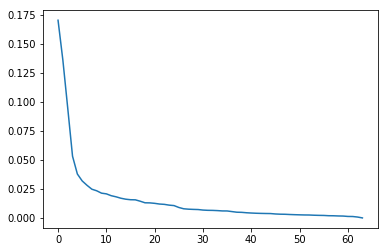

In [111]:
# Investigate the variance accounted for by each principal component.
variance_array = pca.explained_variance_ratio_
plt.plot(variance_array)


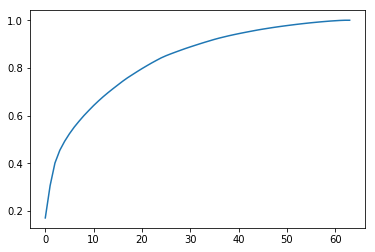

In [112]:
plt.plot(np.cumsum(variance_array))

In [113]:
no_of_components = 12
print ('{:.0f}% variance can be explained using {} components'.format(
    np.cumsum(variance_array)[no_of_components]*100, no_of_components))

68% variance can be explained using 12 components


In [114]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca = PCA(n_components=no_of_components)
pca.fit(azdias_scaled)

PCA(copy=True, iterated_power='auto', n_components=12, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

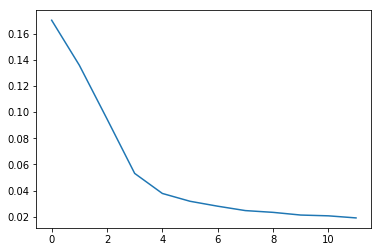

In [115]:
variance_array = pca.explained_variance_ratio_
plt.plot(variance_array)

In [116]:
azdias_pca = pca.transform(azdias_scaled)

In [117]:
azdias_pca.shape

(747109, 12)

In [118]:
azdias_pca = pd.DataFrame(azdias_pca)
azdias_pca.describe()

,0,1,2,3,4,5,6,7,8,9,10,11
count,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05,7.471090e+05
mean,8.186693e-17,6.454344e-17,2.971100e-17,-1.283355e-16,4.896989e-17,8.839117e-17,4.744820e-17,1.322254e-16,1.253302e-16,4.776205e-17,4.913157e-17,1.105127e-17
std,3.300084e+00,2.947858e+00,2.462655e+00,1.844265e+00,1.555931e+00,1.427925e+00,1.340839e+00,1.258341e+00,1.223458e+00,1.168461e+00,1.151985e+00,1.107027e+00
min,-7.952419e+00,-7.918510e+00,-5.422306e+00,-5.401614e+00,-6.360401e+00,-3.850457e+00,-5.607859e+00,-8.930665e+00,-4.587085e+00,-5.720276e+00,-7.242357e+00,-2.569066e+00
25%,-2.775138e+00,-2.214517e+00,-2.228629e+00,-1.333531e+00,-9.932985e-01,-9.395857e-01,-9.024399e-01,-8.589601e-01,-8.584404e-01,-7.551742e-01,-7.696899e-01,-4.829872e-01
50%,-1.506327e-01,4.065337e-02,-4.209035e-01,-2.078805e-01,8.997460e-02,-9.971942e-02,3.613015e-02,-6.164497e-02,2.956384e-03,8.432763e-02,-1.435039e-02,-7.487067e-02
75%,2.639794e+00,2.163427e+00,2.298166e+00,1.100394e+00,1.060502e+00,7.496459e-01,9.387471e-01,8.145765e-01,8.477412e-01,8.151644e-01,7.756700e-01,3.375654e-01
max,1.184491e+01,1.091368e+01,6.401813e+00,8.273054e+00,6.835664e+00,2.698310e+01,1.005514e+01,1.113468e+01,1.103096e+01,8.309440e+00,1.019655e+01,4.310400e+01


### Discussion 2.2: Perform Dimensionality Reduction

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding dimensionality reduction. How many principal components / transformed features are you retaining for the next step of the analysis?)

* No of principal components to be used = 12
* Decision is based on the cumulative plot. 12 princial components can explain 68% of the variance

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [119]:
component_explanation = pd.DataFrame(np.transpose(pca.components_), index = azdias_scaled.columns.tolist())

In [120]:
def get_top_features(nth_component, component_explanation, top_k = 10):
    series = component_explanation.iloc[:,nth_component]
    print ("Top {} negative features for component {}".format(top_k, nth_component))
    print (series.sort_values(ascending = True)[:top_k])
    print ("Top {} positive features for component {}".format(top_k, nth_component))
    print (series.sort_values(ascending = False)[:top_k])

In [121]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
get_top_features(0, component_explanation)

Top 10 negative features for component 0
MOBI_REGIO            -0.241541
KBA05_ANTG1           -0.225093
PLZ8_ANTG1            -0.224957
FINANZ_MINIMALIST     -0.219377
KBA05_GBZ             -0.216593
PLZ8_GBZ              -0.167096
KONSUMNAEHE           -0.165816
INNENSTADT            -0.162830
BALLRAUM              -0.125344
life_stage_category   -0.125128
Name: 0, dtype: float64
Top 10 positive features for component 0
PLZ8_ANTG3            0.224929
PLZ8_ANTG4            0.218074
wealth_category       0.205910
HH_EINKOMMEN_SCORE    0.202695
ORTSGR_KLS9           0.195096
EWDICHTE              0.193116
FINANZ_HAUSBAUER      0.158826
PLZ8_ANTG2            0.152449
KBA05_ANTG4           0.152242
FINANZ_SPARER         0.147630
Name: 0, dtype: float64


In [122]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
get_top_features(1, component_explanation)


Top 10 negative features for component 1
SEMIO_REL               -0.255349
age_category            -0.248049
FINANZ_SPARER           -0.234057
SEMIO_TRADV             -0.229228
SEMIO_PFLICHT           -0.227974
FINANZ_UNAUFFAELLIGER   -0.225273
SEMIO_KULT              -0.218836
FINANZ_ANLEGER          -0.204945
SEMIO_FAM               -0.180091
SEMIO_RAT               -0.169322
Name: 1, dtype: float64
Top 10 positive features for component 1
ALTERSKATEGORIE_GROB    0.257111
FINANZ_VORSORGER        0.229863
SEMIO_ERL               0.228919
SEMIO_LUST              0.180668
RETOURTYP_BK_S          0.165568
FINANZ_HAUSBAUER        0.118067
W_KEIT_KIND_HH          0.117593
SEMIO_KRIT              0.117111
SEMIO_KAEM              0.111290
PLZ8_ANTG3              0.096635
Name: 1, dtype: float64


In [123]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
get_top_features(2, component_explanation)


Top 10 negative features for component 2
ANREDE_KZ               -0.369483
SEMIO_KAEM              -0.338108
SEMIO_DOM               -0.313744
SEMIO_KRIT              -0.271741
SEMIO_RAT               -0.217229
FINANZ_ANLEGER          -0.187625
SEMIO_ERL               -0.174092
age_category            -0.106963
FINANZ_SPARER           -0.103502
FINANZ_UNAUFFAELLIGER   -0.095724
Name: 2, dtype: float64
Top 10 positive features for component 2
SEMIO_VERT              0.347911
SEMIO_SOZ               0.264092
SEMIO_FAM               0.251313
SEMIO_KULT              0.233464
FINANZ_MINIMALIST       0.156661
RETOURTYP_BK_S          0.112159
FINANZ_VORSORGER        0.099161
W_KEIT_KIND_HH          0.090640
ALTERSKATEGORIE_GROB    0.079484
SEMIO_REL               0.073976
Name: 2, dtype: float64


### Discussion 2.3: Interpret Principal Components

#### Feature 1
Negative components:
* MOBI_REGIO : Movement pattern. Inversely proportional to the movement tendency
* KBA05_ANTG1:Number of 1-2 family houses in the microcell. Directly proportional to the 1-2 family houses in microcell
* PLZ8_ANTG1: Number of 1-2 family houses in the PLZ8 region. Directly proportional to the 1-2 family houses in PLZ8 region

Positive Components:
* PLZ8_ANTG3: Number of 6-10 family houses in the PLZ8 region. Directly proportional to Number of 6-10 family houses in the PLZ8 region
* PLZ8_ANTG4: Number of 10+ family houses in the PLZ8 region. Directly proportional to Number of 10+ family houses in the PLZ8 region
* wealth_category: How wealthy is a family. Inversely proportion to the wealth

**Final Comments**: 
This feature seems to explain the wealth of a particular region, and living density.

#### Feature 2:
Negative Features:
* SEMIO_REL: Religious personality typology. Inversely proportional to affinity to religion
* age_category: Directly proportional to the age decade. 
* FINANZ_SPARER: Money Saver financial typology. Inversely proportional
The person is very religious, young, and high affinity to saving money
Positive Features:
* ALTERSKATEGORIE_GROB: Estimated age: Directly proportional, but 9 is uniformly distributed. 
* FINANZ_VORSORGER: be_prepared financial typologoy. Inversely proportional
* SEMIO_ERL: event oriented. Inversely proportional
* SEMIO_LUST: sensual orientaion. Inversely proportional
Person is not financially prepared, and not oriented towards events or senualness. 

**Final Comments**: This feature seems to explain age, financial typology, and personality type. 

#### Feature 3:
Negative Features:
* ANREDE_KZ: 1- Male, 2 - Female [More males]
* SEMIO_KAEM: Combative attitude. Inverse Proportion [High affinity for combative attitude]
* SEMIO_DOM: Dominant. [High affinity]
* SEMIO_KRIT: Critical minded. [HIgh affinity]
* SEMIO_RAT: Rational [High Affinity]

Positive Feature:
* SEMIO_VERT: Dreamful [Low Affinity]
* SEMIO_SOZ: socially-minded [Low Affinity]
* SEMIO_FAM: family-minded [Low Affinity]
* SEMIO_KULT: cultural-minded [Low Affinity]

The 3rd feature is a combination of gender, and personality type, separating out mostly males, highly dominant, critial minded, rational, with low affinity towards dreamfulness, socially-mindedness, family-mindedness, and cultural mindedness. 

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [43]:
# Over a number of different cluster counts...
scores = {}
for n_clusters in range(2, 20):
    kmeans = KMeans(n_clusters = n_clusters)
    kmeans.fit(azdias_pca)
    scores[n_clusters] = np.abs(kmeans.score(azdias_pca))
    print('Finished cluster number {}'.format(n_clusters))

Finished cluster number 2
Finished cluster number 3
Finished cluster number 4
Finished cluster number 5
Finished cluster number 6
Finished cluster number 7
Finished cluster number 8
Finished cluster number 9
Finished cluster number 10
Finished cluster number 11
Finished cluster number 12
Finished cluster number 13
Finished cluster number 14
Finished cluster number 15
Finished cluster number 16
Finished cluster number 17
Finished cluster number 18
Finished cluster number 19


In [36]:
score_series =  pd.Series(scores)

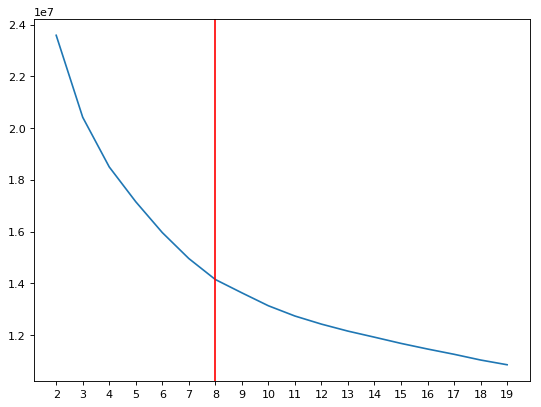

In [37]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.figure(num=None, figsize=(8, 6), dpi=80, facecolor='w', edgecolor='k')
plt.plot(score_series)
plt.xticks(np.arange(2, 20, step=1))
plt.axvline(x=8, color = 'r')

In [124]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters = 8)
kmeans.fit(azdias_pca)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=8, n_init=10, n_jobs=1, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [125]:
kmeans.labels_.shape

(747109,)

In [126]:
kmeans.cluster_centers_.shape

(8, 12)

### Discussion 3.1: Apply Clustering to General Population

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding clustering. Into how many clusters have you decided to segment the population?)

* No of clusters in which the population will be divided into = 8
* This number was obtained using the graph, and seeing the 'elbow' in the pca.score, as compared to the number of clusters

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [129]:
# Load in the customer demographics data.
customers =  pd.read_csv('./Udacity_CUSTOMERS_Subset.csv',
                     delimiter = ";" )

In [130]:
customers.shape

(191652, 85)

In [128]:
customers_cleaned = clean_data(customers, feat_info)

In [131]:
customers_cleaned.shape

(133427, 64)

Impute the missing values

In [132]:
# Apply preprocessing
customers_cleaned_imputed = imputer.transform(customers_cleaned)
customers_cleaned_imputed.shape

(133427, 64)

Scale the data to have mean = 0, and std deviation = 1

In [133]:
# feature transformation
customers_scaled_trasformed =  scaler.transform(customers_cleaned_imputed)
customers_scaled_trasformed.shape

(133427, 64)

In [134]:
customers_scaled = pd.DataFrame(customers_scaled_trasformed)
customers_scaled.columns = customers_cleaned.columns.tolist()
customers_scaled.describe()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,RETOURTYP_BK_S,SEMIO_SOZ,SEMIO_FAM,SEMIO_REL,SEMIO_MAT,SEMIO_VERT,SEMIO_LUST,SEMIO_ERL,SEMIO_KULT,SEMIO_RAT,SEMIO_KRIT,SEMIO_DOM,SEMIO_KAEM,SEMIO_PFLICHT,SEMIO_TRADV,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,HH_EINKOMMEN_SCORE,W_KEIT_KIND_HH,WOHNDAUER_2008,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,KONSUMNAEHE,MIN_GEBAEUDEJAHR,OST_WEST_KZ,KBA05_ANTG1,KBA05_ANTG2,KBA05_ANTG3,KBA05_ANTG4,KBA05_GBZ,BALLRAUM,EWDICHTE,INNENSTADT,GEBAEUDETYP_RASTER,KKK,MOBI_REGIO,ONLINE_AFFINITAET,REGIOTYP,KBA13_ANZAHL_PKW,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,age_category,movement_category,wealth_category,life_stage_category
count,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,1.334270e+05,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,1.334270e+05,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,1.334270e+05,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000,133427.000000
mean,0.686541,-0.379569,0.883857,-0.861946,0.818334,-0.837443,-0.558524,-0.286390,0.681591,-0.316182,0.337275,0.093936,-0.116428,-0.412723,-0.211246,0.471547,0.576237,0.140052,-0.118163,-0.608634,-0.360047,-0.304780,-0.372744,-0.619413,-0.467122,0.015560,-5.015304e-02,0.467464,0.240315,-0.779022,0.053967,0.388760,-0.218705,0.075334,0.084412,-0.062583,0.328350,0.501593,-0.044609,-0.308885,-0.236044,0.351726,0.073777,-0.043816,0.122934,0.128266,-3.023363e-01,0.459792,0.153045,-0.265767,0.143899,0.298661,-0.081563,-0.216386,-0.223593,2.168169e-02,0.221314,-0.354754,-0.085207,-0.134749,-1.004330,0.675182,-0.468411,0.336392
std,0.702380,0.940570,0.741005,0.551340,0.600144,0.676080,0.685117,0.943753,1.200251,1.032401,0.814203,0.830295,0.871480,0.764397,1.029727,0.909636,0.762578,0.958952,0.891851,0.829925,1.014208,0.865244,0.956095,0.762279,0.782281,1.080535,1.011086e+00,1.199510,2.239784,1.083902,1.065670,0.571348,0.890163,1.587155,0.930532,0.960746,0.658278,0.984577,0.872599,0.754528,0.746546,0.879392,0.966980,0.936459,0.965906,0.899953,1.035582e+00,0.897560,0.872558,1.069886,1.004003,0.931520,0.913771,0.897517,0.876044,9.600109e-01,0.907529,1.012968,0.938764,1.046900,0.924064,1.201486,0.962407,0.899707
min,-1.754375,-1.038573,-1.503661,-1.140479,-1.773085,-1.237743,-1.152912,-1.552848,-0.536372,-1.626167,-1.664842,-1.634520,-1.624916,-1.560679,-1.481107,-1.695979,-1.598173,-1.986223,-1.606682,-1.727657,-2.021379,-1.950166,-1.752070,-1.678194,-1.544948,-0.091952,-1.075943e+00,-1.497732,-0.060769,-2.251596,-1.864813,-3.674084,-0.476837,-0.128187,-1.299221,-3.627037,-1.918666,-1.076548,-1.023779,-0.619065,-0.478966,-1.640960,-1.437695,-1.723308,-1.742384,-2.974855,-1.814663e+00,-1.391557,-1.751633,-1.949327,-1.812228,-2.313990,-3.059920,-1.628748,-0.968313,-2.694387e+00,-2.139410,-2.195102,-1.880689,-1.538870,-2.296567,-0.549948,-1.561358,-1.259383
25%,0.198908,-1.038573,0.685685,-1.140479,0.397566,-1.237743,-1.152912,-0.831846,-0.536372,-1.626167,-0.293297,-0.607016,-1.100392,-1.033604,-1.481107,-0.140559,0.305725,-0.891062,-0.587191,-1.126230,-0.872633,-0.857462,-1.219433,-1.146890,-0.979531,-0.091952,-1.075943e+00,-0.637621,-0.060769,-1.600927,-1.280848,0.551338,-0.476837,-0.128187,-0.652182,-0.385050,0.521195,-0.360798,-1.023779,-0.619065,-0.478966,

In [135]:
# Dimensionality reduction
customers_pca = pca.transform(customers_scaled)
customers_pca.shape

(133427, 12)

In [136]:
customers_pca = pd.DataFrame(customers_pca)
customers_pca.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,-5.880819,0.668157,4.240943,2.146526,-3.105123,0.836311,-1.666206,0.810384,0.661772,0.982455,-0.675240,-1.015145
1,-1.703689,4.834768,-0.656797,2.193422,0.946116,-0.884383,-0.154989,-0.904568,-0.797555,1.003214,-1.111476,-0.198880
2,-4.335062,0.164786,2.662375,-2.419830,-0.979547,1.024660,-0.540033,-1.316346,0.377076,0.985140,0.222990,-0.483091
3,1.513852,-0.884938,1.166374,-0.648418,0.110313,-1.778944,1.484583,1.032956,0.021493,2.942090,2.308098,0.198505
4,-2.426549,1.204742,2.875737,2.799759,-2.098287,-1.141143,0.435628,0.442190,-0.790824,-1.578747,0.436616,0.957999


In [137]:
# clustering from the general demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_kmeans = kmeans.predict(customers_pca)
customers_kmeans.shape

(133427,)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [138]:
label, counts = np.unique(kmeans.labels_, return_counts=True)
gen_population_clusters = pd.DataFrame({'label' : label, 'counts': counts})
total_population = gen_population_clusters['counts'].sum()
gen_population_clusters['count_perc'] = gen_population_clusters['counts'].map(lambda x : x*100/total_population)
gen_population_clusters

,counts,label,count_perc
0,104264,0,13.955661
1,66188,1,8.859216
2,125186,2,16.756056
3,100656,3,13.472733
4,67209,4,8.995876
5,78458,5,10.501547
6,122907,6,16.451013
7,82241,7,11.007898


In [139]:
label, counts = np.unique(customers_kmeans, return_counts=True)
customers_clusters = pd.DataFrame({'label' : label, 'counts': counts})
total_population = customers_clusters['counts'].sum()
customers_clusters['count_perc'] = customers_clusters['counts'].map(lambda x : x*100/total_population)
customers_clusters

,counts,label,count_perc
0,14162,0,10.614044
1,1329,1,0.996050
2,67652,2,50.703381
3,16978,3,12.724561
4,3542,4,2.654635
5,1383,5,1.036522
6,25921,6,19.427102
7,2460,7,1.843705


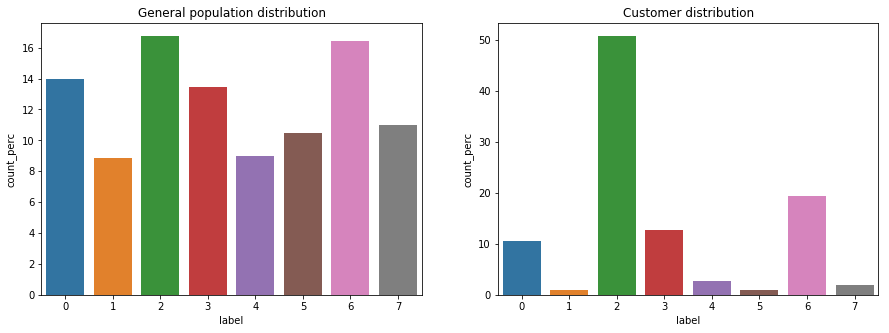

In [140]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

fig, axes = plt.subplots(1,2, figsize=(15, 5))
ax = sns.barplot(x = 'label', y = 'count_perc', data = gen_population_clusters, ax = axes[0])
ax.set_title('General population distribution')
ax = sns.barplot(x = 'label', y = 'count_perc', data = customers_clusters, ax= axes[1])
ax.set_title('Customer distribution')
plt.show()

In [141]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
label = 2 # Over represented in the customer population
get_top_features(label, component_explanation)



Top 10 negative features for component 2
ANREDE_KZ               -0.369483
SEMIO_KAEM              -0.338108
SEMIO_DOM               -0.313744
SEMIO_KRIT              -0.271741
SEMIO_RAT               -0.217229
FINANZ_ANLEGER          -0.187625
SEMIO_ERL               -0.174092
age_category            -0.106963
FINANZ_SPARER           -0.103502
FINANZ_UNAUFFAELLIGER   -0.095724
Name: 2, dtype: float64
Top 10 positive features for component 2
SEMIO_VERT              0.347911
SEMIO_SOZ               0.264092
SEMIO_FAM               0.251313
SEMIO_KULT              0.233464
FINANZ_MINIMALIST       0.156661
RETOURTYP_BK_S          0.112159
FINANZ_VORSORGER        0.099161
W_KEIT_KIND_HH          0.090640
ALTERSKATEGORIE_GROB    0.079484
SEMIO_REL               0.073976
Name: 2, dtype: float64


In [143]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
label = 5 # Over represented in the customer population
get_top_features(label, component_explanation)


Top 10 negative features for component 5
KBA05_ANTG2          -0.393898
PLZ8_ANTG2           -0.275769
KBA05_ANTG3          -0.209764
RELAT_AB             -0.209384
REGIOTYP             -0.204674
KKK                  -0.195169
GEBAEUDETYP_RASTER   -0.190139
ARBEIT               -0.170130
KBA05_GBZ            -0.152069
OST_WEST_KZ          -0.134678
Name: 5, dtype: float64
Top 10 positive features for component 5
KBA05_ANTG4            0.431379
ANZ_HAUSHALTE_AKTIV    0.384793
ANZ_HH_TITEL           0.265665
PLZ8_ANTG4             0.087548
ANZ_TITEL              0.072728
life_stage_category    0.057118
MIN_GEBAEUDEJAHR       0.041682
FINANZ_HAUSBAUER       0.040902
PLZ8_ANTG1             0.040484
SEMIO_TRADV            0.036290
Name: 5, dtype: float64


### Discussion 3.3: Compare Customer Data to Demographics Data

(Double-click this cell and replace this text with your own text, reporting findings and conclusions from the clustering analysis. Can we describe segments of the population that are relatively popular with the mail-order company, or relatively unpopular with the company?)

#### Over represented in the customer population
Label = 2, or the 3rd cluster is over represented. 
Negative Features:
* ANREDE_KZ: 1- Male, 2 - Female [More males]
* SEMIO_KAEM: Combative attitude. Inverse Proportion [High affinity for combative attitude]
* SEMIO_DOM: Dominant. [High affinity]
* SEMIO_KRIT: Critical minded. [HIgh affinity]
* SEMIO_RAT: Rational [High Affinity]

Positive Feature:
* SEMIO_VERT: Dreamful [Low Affinity]
* SEMIO_SOZ: socially-minded [Low Affinity]
* SEMIO_FAM: family-minded [Low Affinity]
* SEMIO_KULT: cultural-minded [Low Affinity]

Therefore company customers are **mostly males, highly dominant, critial minded, rational, with low affinity towards dreamfulness, socially-mindedness, family-mindedness, and cultural mindedness**.  

#### Under represented in the customer population
label = 5 or 6th cluster
Negative Features:
* KBA05_ANTG2: No of 3-5 family houses in micro cell [Lower share]
* PLZ8_ANTG2: No of 3-5 family houses in plz8 [Lower share]
* KBA05_ANTG3:  No of 6 - 10 family houses in micro cell [Lower share]
Positive Features:
* KBA05_ANTG4: No of 10+ houses in micro cell [Higher share]
* ANZ_HAUSHALTE_AKTIV: No of households in the building [Higher share]
* ANZ_HH_TITEL: No of professional academic title holders in the building [Higher share]

There people who are **living in high density areas are less probable to be company customers**


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.

**References**:

https://stackoverflow.com/questions/12067446/how-many-principal-components-to-take

https://www.quora.com/What-is-the-best-way-to-choose-the-number-of-components-in-PCA-during-dimensionality-reduction

https://stackoverflow.com/questions/22984335/recovering-features-names-of-explained-variance-ratio-in-pca-with-sklearn

https://stackoverflow.com/questions/332289/how-do-you-change-the-size-of-figures-drawn-with-matplotlib

https://stackoverflow.com/questions/46379095/convert-two-numpy-array-to-dataframe
